# MNIST Project
> **By Jisang Yun**

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [21]:
class CustomMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        item = self.data_frame.iloc[idx]

        if self.is_test:
            Image = item.values.reshape(28, 28).astype(np.uint8)
            label = None
        else:
            Image = item[1:].values.reshape(28, 28).astype(np.uint8)
            label = item.iloc[0]

        Image = transforms.ToPILImage()(Image)

        if self.transform is not None:
            Image = self.transform(Image)

        if self.is_test:
            return Image
        else:
            return Image, label

In [22]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [48]:
train_dataset = CustomMNISTDataset(csv_file='./digit-recognizer/train.csv', transform=transform, is_test=False)
test_dataset = CustomMNISTDataset(csv_file='./digit-recognizer/test.csv', transform=transform, is_test=True)

In [49]:
print('Train Size: ' + str(len(train_dataset)) + ', Test Size: ' + str(len(test_dataset)))

Train Size: 42000, Test Size: 28000


In [50]:
train_dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [51]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Input Size: torch.Size([64, 1, 28, 28])


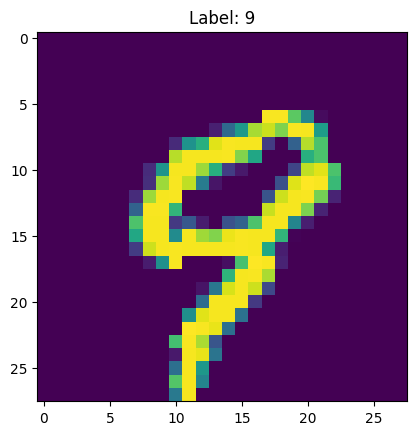

In [55]:
for example_data, example_labels in train_loader:
    example_image = example_data[0]
    print("Input Size:", example_data.size())
    
    example_image_numpy = example_image.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization

    plt.imshow(example_image_numpy)
    plt.title(f"Label: {example_labels[0]}")
    plt.show()

    break

In [44]:
class SimpleCNN(nn.Module):
   def __init__(self):
       super(SimpleCNN, self).__init__()
       # Convolutional layers
       self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
       self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
       self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
       
       # Activation and pooling layers
       self.relu = nn.ReLU()
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Only define once
       
       # Automatically calculate the input size for fully connected layer
       self.fc_input_size = self._get_conv_output_size()
       
       # Fully connected layers
       self.fc1 = nn.Linear(self.fc_input_size, 128)
       self.dropout = nn.Dropout(0.5)
       self.fc2 = nn.Linear(128, 20)
       self.fc3 = nn.Linear(20, 10)

   def _get_conv_output_size(self):
       """Automatically calculate the output size of convolutional layers"""
       with torch.no_grad():
           # Test with MNIST image size (1, 28, 28)
           x = torch.zeros(1, 1, 28, 28)
           
           # Forward pass through conv layers
           x = self.pool(self.relu(self.conv1(x)))  # 28x28 -> 14x14
           x = self.pool(self.relu(self.conv2(x)))  # 14x14 -> 7x7
           x = self.pool(self.relu(self.conv3(x)))  # 7x7 -> 3x3
           
           return x.view(1, -1).size(1)

   def forward(self, x):
       # Convolutional layers with ReLU and pooling
       x = self.pool(self.relu(self.conv1(x)))  # (batch, 32, 14, 14)
       x = self.pool(self.relu(self.conv2(x)))  # (batch, 64, 7, 7)
       x = self.pool(self.relu(self.conv3(x)))  # (batch, 128, 3, 3)
       
       # Flatten the tensor for fully connected layers
       x = x.view(x.size(0), -1)  # Safer and simpler method
       
       # Fully connected layers
       x = self.relu(self.fc1(x))
       x = self.dropout(x)
       x = self.relu(self.fc2(x))  # Add ReLU to fc2 as well
       x = self.fc3(x)  # Final output layer (no activation)
       
       return x


In [45]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [46]:
num_epochs = 100
running_loss = 0.0

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print('Finished Training')

[1, 100] loss: 1.559
[1, 200] loss: 0.521
[1, 300] loss: 0.357
[1, 400] loss: 0.262
[1, 500] loss: 0.221
[1, 600] loss: 0.216
[2, 100] loss: 0.274
[2, 200] loss: 0.165
[2, 300] loss: 0.150
[2, 400] loss: 0.154
[2, 500] loss: 0.131
[2, 600] loss: 0.130
[3, 100] loss: 0.205
[3, 200] loss: 0.115
[3, 300] loss: 0.101
[3, 400] loss: 0.110
[3, 500] loss: 0.094
[3, 600] loss: 0.111
[4, 100] loss: 0.160
[4, 200] loss: 0.084
[4, 300] loss: 0.096
[4, 400] loss: 0.087
[4, 500] loss: 0.085
[4, 600] loss: 0.091
[5, 100] loss: 0.125
[5, 200] loss: 0.083
[5, 300] loss: 0.074
[5, 400] loss: 0.071
[5, 500] loss: 0.078
[5, 600] loss: 0.086
[6, 100] loss: 0.107
[6, 200] loss: 0.068
[6, 300] loss: 0.066
[6, 400] loss: 0.071
[6, 500] loss: 0.072
[6, 600] loss: 0.065
[7, 100] loss: 0.095
[7, 200] loss: 0.068
[7, 300] loss: 0.063
[7, 400] loss: 0.068
[7, 500] loss: 0.066
[7, 600] loss: 0.056
[8, 100] loss: 0.081
[8, 200] loss: 0.054
[8, 300] loss: 0.047
[8, 400] loss: 0.055
[8, 500] loss: 0.056
[8, 600] loss

In [57]:
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().tolist())

submission = pd.DataFrame({
    "ImageId": range(1, len(predictions) + 1),
    "Label": predictions
})

submission.to_csv('submission.csv', index=False)